# Recipients of subsidy to private day-care and day-care of own children by region

In this project we investigate the development in the popularity of private day-care.

**$\large \color{lightblue}{{Imports}\:{and}\:{set}\:{Magics}}$**

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2

from ipywidgets import interact


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In the following we have identified the tables of interest, and the subject under which we find them. 

In [254]:
# Setup data loader with the langauge 'english'
Dst = pydst.Dst(lang='en') 

# Get a list of all subjects 
Dst.get_subjects() 

# Get all tables in subject '1' (people)
tables = Dst.get_tables(subjects=['1']) 

# Display only the tables in '1' containing 'Recipients of subsidy to private day-care and' in the text because we know that the table of interest contains this in its title 
display(tables[tables['text'].str.contains('Recipients of subsidy to private day-care and')])

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
137,DAGTIL4,Recipients of subsidy to private day-care and ...,Number,2022-03-30 08:00:00,2008,2021,True,"[region, grant type, affected , time]"


$\large 1.$ **$\large \color{lightblue}{Import}\:{and}\:{Arrange}\:{Data}$**


We import data from DAGTIL4 and BY2

DAGTIL4 contains information on the type of subsidity granted: "Subsidy for day-care of own children" or "Subsidy to parents who choose private day-care". Additionally, who the affected party is; the Children or the Family.

BY2 contains information on the number of peopel of a certain age within each Municipality and the gender. Furthermore, the size of the municipality. 

Both data sets have a Municipality dimension, and a year-time dimention. These we use, when merging the data sets. 

In [255]:
# Importing the data from DAGTIL4
Rec_vars = Dst.get_variables(table_id='DAGTIL4')
Rec_vars

# Make the Dataframe
variables_rec = {'OMRÅDE':['*'],'TILSKUDSART':['*'],'BERORT':['*'], 'TID':['*']}
rec_gen= Dst.get_data(table_id = 'DAGTIL4', variables=variables_rec)
rec_gen.sort_values(by=['TID', 'OMRÅDE'], inplace=True)

# On municipality and year level, sum the number of recipients of each subsidy type
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID', 'BERORT','TILSKUDSART']).sum().reset_index()

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy for day-care of own children'
rec_gen['own_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Children' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_child'] = rec_gen[(rec_gen['BERORT'] == 'Children') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['pri_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy to parents who choose private day-care')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')
# Generate 1 new column for OMRÅDE AND TID with INDHOLD for BERORT = 'Families' and TILSKUDSART = 'Subsidy to parents who choose private day-care'
rec_gen['own_fam'] = rec_gen[(rec_gen['BERORT'] == 'Families') & (rec_gen['TILSKUDSART'] == 'Subsidy for day-care of own children')].groupby(['OMRÅDE', 'TID'])['INDHOLD'].transform('sum')

# Replace NaN with 0
rec_gen = rec_gen.fillna(0)
# Replace .. with 0
rec_gen = rec_gen.replace('..', 0)

# drop the INDHOLD, BERORT and TILSKUDSART columns
rec_gen = rec_gen.drop(columns=['INDHOLD','BERORT', 'TILSKUDSART'])

# Convert the own_child, pri_child, pri_fam and own_fam columns to integers
rec_gen['own_child'] = rec_gen['own_child'].astype(int)
rec_gen['pri_child'] = rec_gen['pri_child'].astype(int)
rec_gen['pri_fam'] = rec_gen['pri_fam'].astype(int)
rec_gen['own_fam'] = rec_gen['own_fam'].astype(int)

# For each OMRÅDE AND TID, sum the 'own_child', 'pri_child', 'pri_fam' and 'own_fam' columns
rec_gen = rec_gen.groupby(['OMRÅDE', 'TID']).sum().reset_index()

# Rename the columns
rec_gen = rec_gen.rename(columns={'OMRÅDE':'Municipality', 'TID':'Year'})

# Show the Dataframe
rec_gen.head(5)

,Municipality,Year,own_child,pri_child,pri_fam,own_fam
0,Aabenraa,2008,14,23,20,14
1,Aabenraa,2009,13,17,15,11
2,Aabenraa,2010,11,38,36,10
3,Aabenraa,2011,7,78,75,7
4,Aabenraa,2012,10,86,86,10


In [256]:
# Importing the data from BY2
By_vars = Dst.get_variables(table_id='BY2')
By_vars

# Make the Dataframe
variables_by = {'KOMK':['*'],'BYST':['*'],'ALDER':['*'], 'Tid':['*']}
by_gen= Dst.get_data(table_id = 'BY2', variables=variables_by)
by_gen.sort_values(by=['TID', 'KOMK'], inplace=True)

# Rename the columns
by_gen = by_gen.rename(columns={'KOMK':'Municipality','ALDER':'Age', 'TID':'Year'})

# Remove non-numeric characters from the "Age" column (the observations in 'Age' are of the type "51 years" and not "51") 
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum()

# Convert the "Age" column to string type
by_gen['Age'] = by_gen['Age'].astype(str)

# Remove non-numeric characters from the "Age" column
by_gen['Age'] = by_gen['Age'].str.replace(' years?', '', regex=True).astype(int)

# Filter the dataset to select rows where Age is between 0 and 6 years
age_0_to_6 = by_gen[(by_gen['Age'] >= 0) & (by_gen['Age'] <= 6)]

# Group the data by Municipality and Year and sum the number of persons
grouped_data = age_0_to_6.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
grouped_data = grouped_data.rename(columns={'INDHOLD': 'Residents aged 0-6 years'})

# Add a new column for the total number of residents
total_residents = by_gen.groupby(['Municipality', 'Year'])['INDHOLD'].sum().reset_index()
total_residents = total_residents.rename(columns={'INDHOLD': 'Total number of residents'})

# Merge the two dataframes
data2 = pd.merge(grouped_data, total_residents, on=['Municipality', 'Year'])

# Show the dataframe
data2.head(5)

,Municipality,Year,Residents aged 0-6 years,Total number of residents
0,Aabenraa,2010,2414,29913
1,Aabenraa,2011,2381,29795
2,Aabenraa,2012,2321,29704
3,Aabenraa,2013,2221,29536
4,Aabenraa,2014,2122,29386


$\large 2.$  **$\large \color{lightblue}{Merge}$** 

In [257]:
one2one = pd.merge(data2,rec_gen,on=['Municipality', 'Year'],how='inner') # Merge the two dataframes by Municipality and Year
# one2one

$\large 3.$  **$\large \color{lightpurple}{General}\:{Development}$** 

In order to be explore the data, we construct both static and interactive plots. 

Below we display the development in the fraction of the total Danish population that is between 0 and 6 years old. This show a clear negative trend (see Fig. 1).

However, Fig. 2 shows an increase in the proportion of 0-6 year who receive a subsidity for private daycare. 

C:\Users\Louise Boe Prahl\AppData\Local\Temp\ipykernel_12960\1128019668.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_one2one = one2one.groupby('Year').sum()


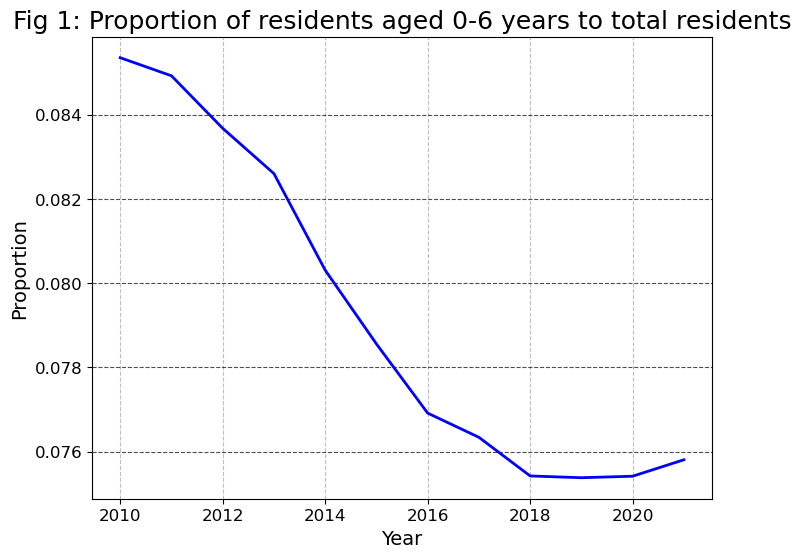

In [258]:
# Create a plot of proportion of residents aged 0-6 years to total residents

# Group the data by year and sum the columns for all municipalities
grouped_one2one = one2one.groupby('Year').sum()

# Calculate the proportion of residents aged 0-6 years to total residents
grouped_one2one['proportion'] = grouped_one2one['Residents aged 0-6 years'] / grouped_one2one['Total number of residents']

# Create a line plot of the proportion over time
fig, ax = plt.subplots(figsize=(8, 6))
grouped_one2one['proportion'].plot(kind='line', ax=ax, linewidth=2, color='blue')

# Set plot title and axis labels
ax.set_title('Fig 1: Proportion of residents aged 0-6 years to total residents', fontsize=18)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)

# Customize tick labels and grid lines
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

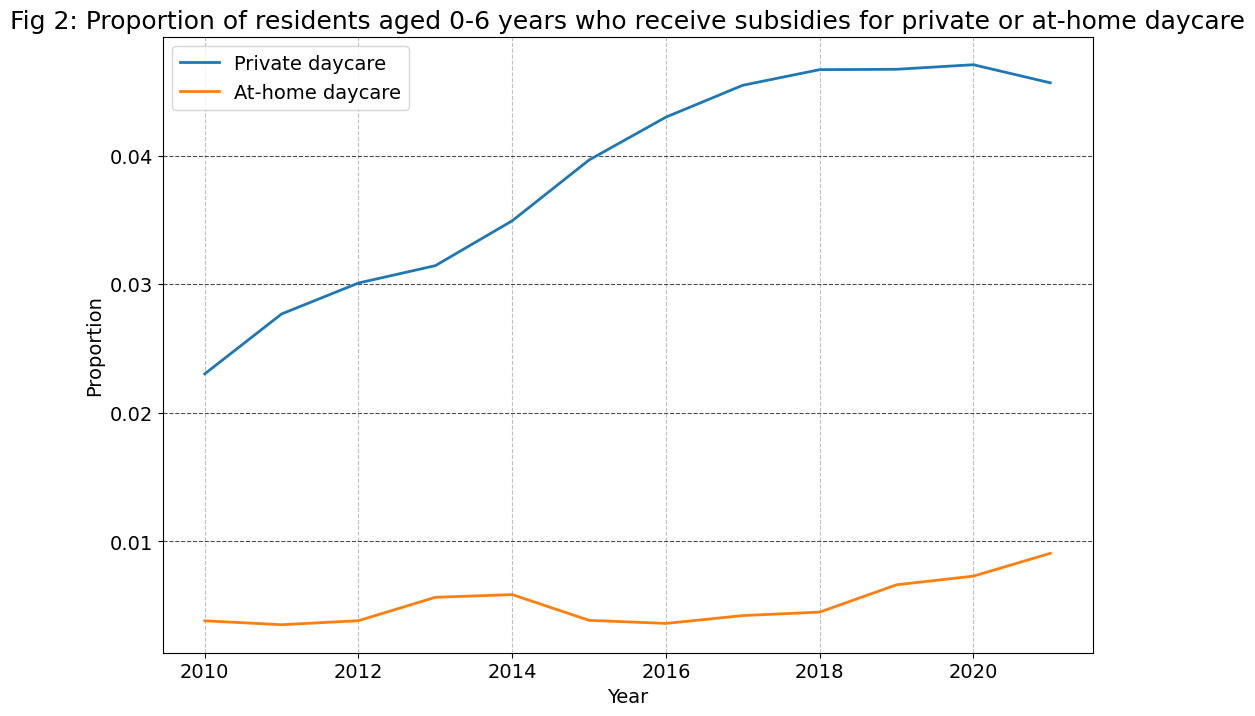

In [259]:
# Create a plot of proportion of residents aged 0-6 years who receives subsidies for private or at-home daycare to total residents aged 0-6 years

# Calculate the proportion of residents aged 0-6 years receiving either type of subsidy to total residents aged 0-6 years
grouped_one2one['proportion_private'] = grouped_one2one['pri_child'] / grouped_one2one['Residents aged 0-6 years']
grouped_one2one['proportion_home'] = grouped_one2one['own_child'] / grouped_one2one['Residents aged 0-6 years']

# Create a line plot of the proportion over time
fig, ax = plt.subplots(figsize=(12, 8))
grouped_one2one[['proportion_private', 'proportion_home']].plot(kind='line', ax=ax, linewidth=2)

# Set plot title and axis labels
ax.set_title('Fig 2: Proportion of residents aged 0-6 years who receive subsidies for private or at-home daycare', fontsize=18)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)

# Customize tick labels and grid lines
ax.tick_params(axis='both', labelsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Customize legend
ax.legend(['Private daycare', 'At-home daycare'], fontsize=14)

plt.show()

$\large 4.$  **$\large \color{lightpurple}{Municipal}\:{Specific}\:{Development}$** 

Interaktiv figur - hvor mange bruger tilbuddene. 
absolut antal - i begge kategorier. 
Et interaktivt plot hvor man kan klikke rundt mellem kommuner? 

In [260]:
# Define function to update plot based on selected municipality
def update_plot(municipality):
    # Filter data to selected municipality
    subset = one2one[one2one['Municipality'] == municipality]
    
    # Group data by year and sum columns for selected municipality
    grouped = subset.groupby('Year').sum()
    
    # Calculate proportion of residents aged 0-6 years receiving either type of subsidy to total residents aged 0-6 years
    grouped['proportion_private'] = grouped['pri_child'] / grouped['Residents aged 0-6 years']
    grouped['proportion_home'] = grouped['own_child'] / grouped['Residents aged 0-6 years']
    
    # Create line plot of proportion over time for selected municipality
    fig, ax = plt.subplots(figsize=(12, 8))
    grouped[['proportion_private', 'proportion_home']].plot(kind='line', ax=ax, linewidth=2)
    
    # Set plot title and axis labels
    ax.set_title(f"Proportion of residents aged 0-6 years who receive subsidies for private or at-home daycare in {municipality}", fontsize=18)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Proportion', fontsize=14)
    
    # Customize tick labels and grid lines
    ax.tick_params(axis='both', labelsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Customize legend
    ax.legend(['Private daycare', 'At-home daycare'], fontsize=14)
    
    plt.show()

# Create dropdown menu of municipality names
municipalities = sorted(one2one['Municipality'].unique())
dropdown = widgets.Dropdown(options=municipalities, value=municipalities[0], description='Municipality:')

# Display dropdown and plot
interact(update_plot, municipality=dropdown);

interactive(children=(Dropdown(description='Municipality:', options=('Aabenraa', 'Aalborg', 'Aarhus', 'Alberts…

In [261]:
one2one

,Municipality,Year,Residents aged 0-6 years,Total number of residents,own_child,pri_child,pri_fam,own_fam
0,Aabenraa,2010,2414,29913,11,38,36,10
1,Aabenraa,2011,2381,29795,7,78,75,7
2,Aabenraa,2012,2321,29704,10,86,86,10
3,Aabenraa,2013,2221,29536,1,120,113,1
4,Aabenraa,2014,2122,29386,0,161,157,0
...,...,...,...,...,...,...,...,...
1137,Ærø,2017,145,3110,0,18,18,0
1138,Ærø,2018,139,3094,0,19,18,0
1139,Ærø,2019,133,3021,0,19,19,0
1140,Ærø,2020,119,2990,0,19,19,0


In [266]:
# # Define function to update plot based on selected municipality
for municipality in municipalities:
    one2one['proportion_private'] = one2one['pri_child'] / one2one['Residents aged 0-6 years']
    one2one['proportion_home'] = one2one['own_child'] / one2one['Residents aged 0-6 years']

#     # Subtract the 2010 value of the proportion from the 2021 value of the proportion for each municipality
#     one2one['change_private'] = one2one['proportion_private'].iloc[-1]-one2one['proportion_private'].iloc[0]
#     one2one['change_home'] = one2one['proportion_home'].iloc[-1]-one2one['proportion_home'].iloc[0] 

#     # Create Dataframe with Municipality, change_private and change_home
#     change = one2one[['Municipality', 'change_private', 'change_home']]
#     change = change.drop_duplicates()

# change


nr_rows=one2one.shape[0] # number of rows in the data

# loop through the data
for i in range(0, nr_rows-1): 
    if one2one.iloc[i, 1] == one2one.iloc[i-1, 1] or one2one.iloc[i, 1] == one2one.iloc[i+1, 1] and one2one.iloc[i, 2] == 2010 or one2one.iloc[i, 2] == 2021: 
        one2one['proportion_private'] = one2one['proportion_private'] #keep value
        one2one['proportion_home'] = one2one['proportion_home'] #keep value
    else:
        one2one['proportion_private'] = 0 #set value to 0
        one2one['proportion_home'] = 0 #set value to 0

one2one
# import matplotlib.pyplot as plt


,Municipality,Year,Residents aged 0-6 years,Total number of residents,own_child,pri_child,pri_fam,own_fam,proportion_private,proportion_home
0,Aabenraa,2010,2414,29913,11,38,36,10,0,0
1,Aabenraa,2011,2381,29795,7,78,75,7,0,0
2,Aabenraa,2012,2321,29704,10,86,86,10,0,0
3,Aabenraa,2013,2221,29536,1,120,113,1,0,0
4,Aabenraa,2014,2122,29386,0,161,157,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1137,Ærø,2017,145,3110,0,18,18,0,0,0
1138,Ærø,2018,139,3094,0,19,18,0,0,0
1139,Ærø,2019,133,3021,0,19,19,0,0,0
1140,Ærø,2020,119,2990,0,19,19,0,0,0


# Conclusion

ADD CONCISE CONLUSION.